In [1]:
import numpy as np
import torch
from tqdm.notebook  import tqdm
import pickle
import copy
from pprint import pprint

from jeffutils.utils import reimport
from models.pytorch_model import OrigamiNetwork
reimport("from models.pytorch_model import OrigamiNetwork", globals())
from vis_helpers import *
reimport("from vis_helpers import *", globals())

### Data

In [2]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 30
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)

## Training

In [3]:
test_case_x = xorX
test_case_y = xorY
print("Testing xor problem")
layers = 2
test = OrigamiNetwork(n_layers=layers, width=None, epochs=300, 
                      learning_rate=0.01, optimizer_type="adam", crease=None)
test.load_data(test_case_x, test_case_y)
# test.set_folds([np.array([-0.00466453, 0.53786325])])
test.fit()
logits, out = test.forward(test_case_x, return_intermediate=True)

# print("\nScore =", test.score(), "after training")
print("Cut", test.get_cut_vector(), "Fold vectors", sep="\n")
pprint(test.get_fold_vectors())

Testing xor problem


Training: 100%|██████████| 300/300 [00:30<00:00,  9.75it/s]

Cut
[[ 1.4900789 -9.964963 ]
 [-1.1300043  9.925472 ]]
Fold vectors
{'Layer 0': {'crease': [7.801], 'hyperplane': [-0.086, 0.075]},
 'Layer 1': {'crease': [3.739], 'hyperplane': [-0.147, -0.215]}}


In [4]:
reimport("from vis_helpers import *", globals())
for l in range(layers):
    plot_wiggles(test.get_history("fold"), test.get_history("crease"), layer=l)

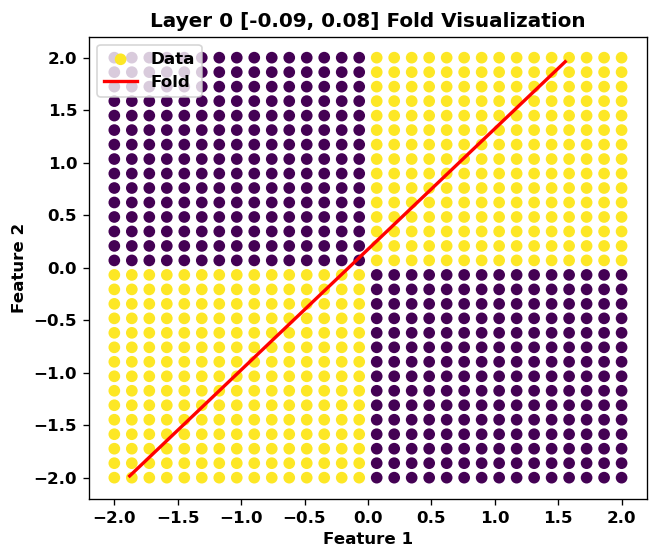

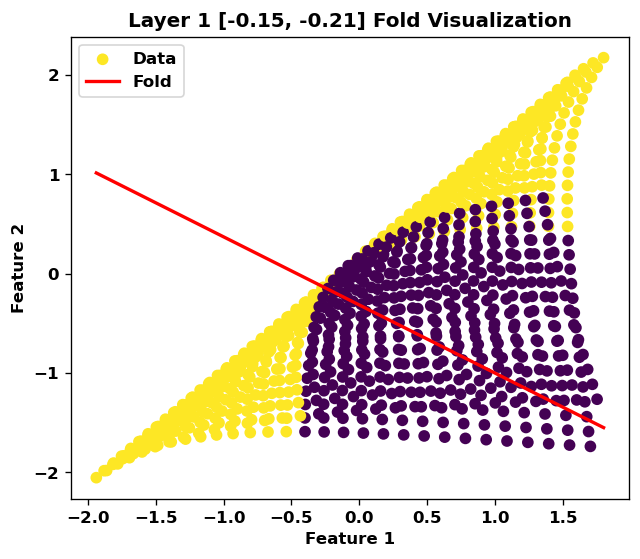

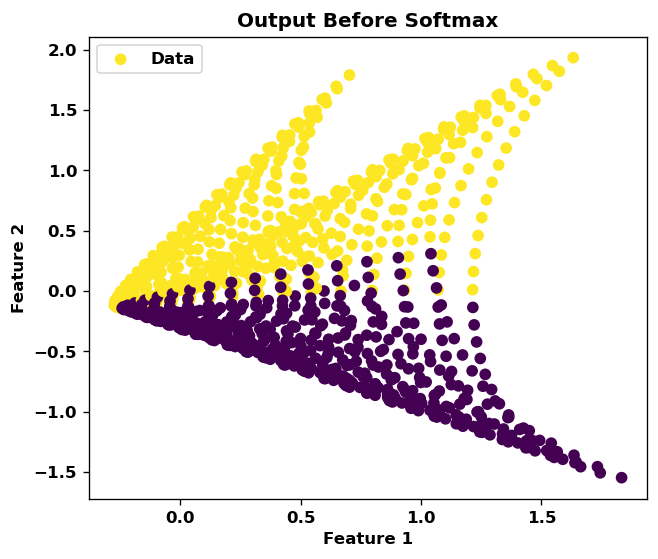

In [5]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
# reimport("from vis_helpers import *", globals())
for layer_index in range(layers+1):
    plot_folds(test, layer_index=layer_index, use_plotly=False)

Plotting: 100%|██████████| 50/50 [00:00<00:00, 1110.46it/s]


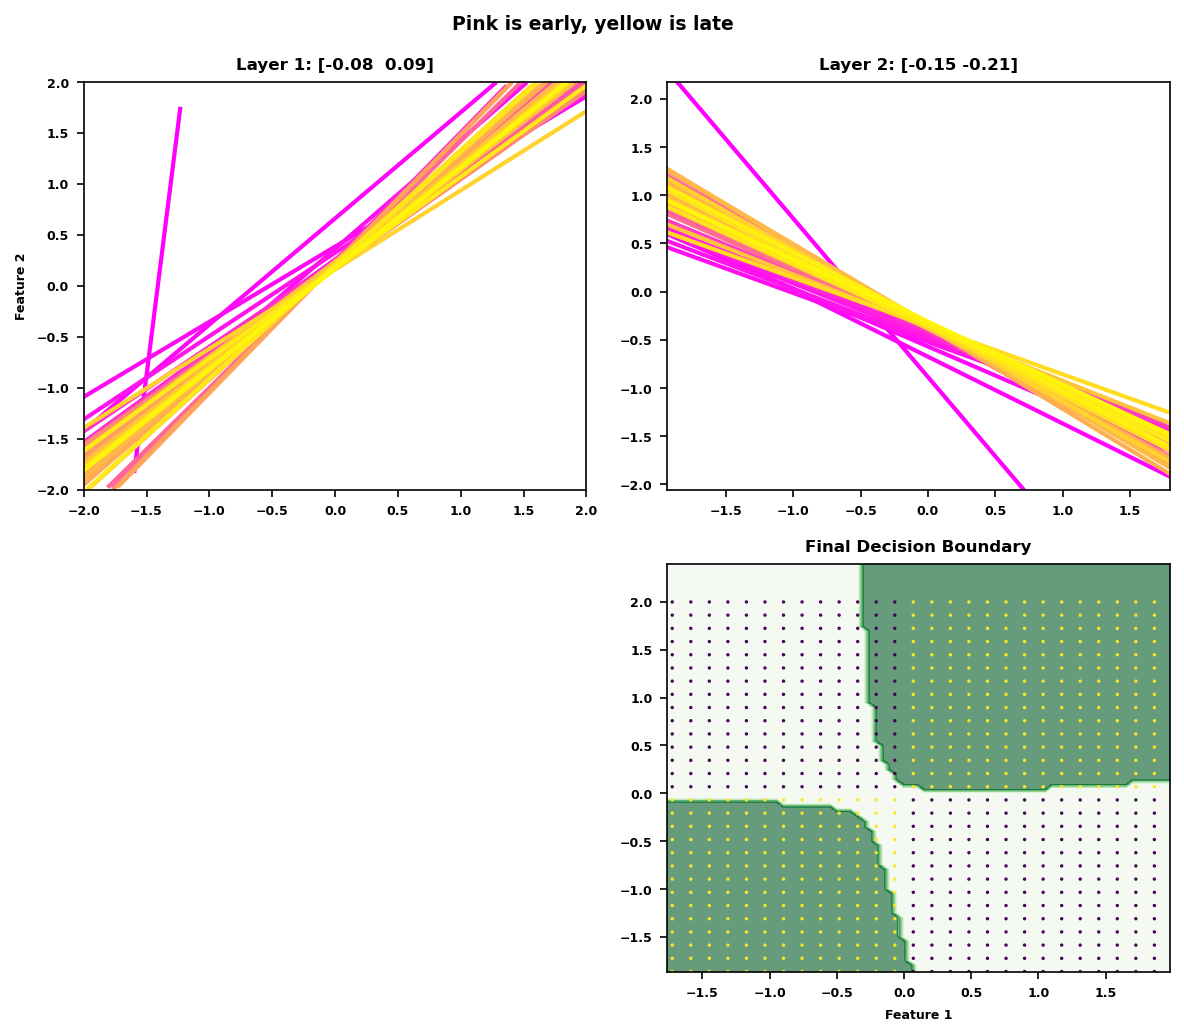

In [6]:
reimport("from vis_helpers import *", globals())
plot_history(test, verbose=2)

In [7]:
pprint(test.get_fold_vectors())

{'Layer 0': {'crease': [7.801], 'hyperplane': [-0.086, 0.075]},
 'Layer 1': {'crease': [3.739], 'hyperplane': [-0.147, -0.215]}}


In [8]:
reimport("from vis_helpers import *", globals())
max_score, best_folds = create_landscape(test, landscape_type="Loss", show_layers=None, create_plot=True, density=61, verbose=1)

Loss Layer 0: 100%|██████████| 3721/3721 [00:05<00:00, 711.47it/s] 


Loss Layer 1: 100%|██████████| 3721/3721 [00:04<00:00, 774.88it/s]


In [9]:
path = []
path_density = 10
layer = 0
f1id, f2id = 0, 1
for i, fold in enumerate(test.fold_history):
    if i % path_density == 0:
        path.append(fold[layer][[f1id, f2id]])
path = np.array(path)[:, 0]
path

array([-1.3954906 , -0.24579117, -0.16139968, -0.12883334, -0.12633309,
       -0.1393642 , -0.11906496, -0.11390172, -0.09422548, -0.10348905,
       -0.1012242 , -0.09922535, -0.10292813, -0.09887036, -0.10121117,
       -0.09580898, -0.10584286, -0.0878042 , -0.11010846, -0.08365629,
       -0.09840906, -0.11150266, -0.08951505, -0.09795531, -0.09412032,
       -0.09475331, -0.08233276, -0.09781951, -0.09920964, -0.08711231],
      dtype=float32)